<a href="https://colab.research.google.com/github/tizianofucci/A2NDLSegmentation/blob/main/Notebook/colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [54]:
import os

# os.environ["CUDA_VISIBLE_DEVICES"]="-1" 
import tensorflow as tf
import numpy as np

# Set the seed for random operations. 
# This let our experiments to be reproducible. 
SEED = 1234
tf.random.set_seed(SEED)  

In [55]:
cwd = os.getcwd()

# Example: Image Segmentation
## Build segmentation

In [56]:
import shutil
import random
import json
import math

SEED = 1234
tf.random.set_seed(SEED)  

# Get current working directory
cwd = os.path.join(os.path.dirname(os.getcwd()),"VQA_Dataset")

#Save all possible path in order to be able to cycle over them
dataset_image_dir = os.path.join(cwd,'Images')

dataset_QA = os.path.join(cwd,'train_questions_annotations.json')

test_QA = os.path.join(cwd,'test_questions.json')


In [57]:
print(dataset_QA)
print(test_QA)

C:\Users\ASUS\Documents\Università\ANNDL\A2NDLVisualQuestionAnswering\VQA_Dataset\train_questions_annotations.json
C:\Users\ASUS\Documents\Università\ANNDL\A2NDLVisualQuestionAnswering\VQA_Dataset\test_questions.json


In [58]:
# Prepare dataset
# ---------------

with open(dataset_QA) as f:
    q_dict = json.load(f)


MAX_NUM_SENTENCES = 40000
MAX_NUM_WORDS = 20000

answers = []
questions = []
eng_sentences_train = []

# Simplify the dataset
MAX_LEN = 7 # words

# Read all lines in translation dataset
count = 0

for key in q_dict:


#for line in open(os.path.join('/content/drive/My Drive', 'ita.txt'), encoding='utf-8'):
    
    if count > MAX_NUM_SENTENCES:
        break

        
    answer = q_dict[key]['answer']
    question = q_dict[key]['question']

    
    if (len(answer.split(' ')) > MAX_LEN or
          len(question.split(' ')) > MAX_LEN):
      continue
    
    question = question + ' <eos>'
    
    questions.append(question)
    answers.append(answer)

    count += 1

print('Number of questions:', len(questions))

Number of questions: 40001


In [59]:
max(len(sentence.split(' ')) for sentence in questions)

8

In [60]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Create Tokenizer to convert words to integers
ita_tokenizer = Tokenizer(num_words= MAX_NUM_WORDS)
ita_tokenizer.fit_on_texts(questions)
ita_tokenized = ita_tokenizer.texts_to_sequences(questions)

ita_wtoi = ita_tokenizer.word_index
print('Total Questions words:', len(ita_wtoi))

max_ita_length = max(len(sentence) for sentence in ita_tokenized)
print('Max question length:', max_ita_length)

Total Questions words: 3364
Max question length: 9


In [61]:
# Pad to max italian sentence length
ita_encoder_inputs = pad_sequences(ita_tokenized, maxlen=max_ita_length)

print("Italian encoder inputs shape:", ita_encoder_inputs.shape)


Italian encoder inputs shape: (40001, 9)


In [79]:
# Build Encoder-Decoder Model
# ---------------------------

EMBEDDING_SIZE = 32

# ENCODER
# -------

encoder_input = tf.keras.Input(shape=[max_ita_length])
encoder_embedding_layer = tf.keras.layers.Embedding(len(ita_wtoi)+1, EMBEDDING_SIZE, input_length=max_ita_length, mask_zero=True)
encoder_embedding_out = encoder_embedding_layer(encoder_input)
encoder = tf.keras.layers.LSTM(units=512, return_state=True)

encoder_output, h, c = encoder(encoder_embedding_out)
encoder_states = [h, c]



# MODEL
model_lstm = tf.keras.Model(encoder_input,encoder_output)

In [80]:
model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 9)]               0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 9, 32)             107680    
_________________________________________________________________
lstm_10 (LSTM)               [(None, 128), (None, 128) 82432     
Total params: 190,112
Trainable params: 190,112
Non-trainable params: 0
_________________________________________________________________


In [81]:
#!zip -r "/content/drive/MyDrive/New_Development_Dataset.zip" "/content/Development_Dataset"

In [82]:
# ImageDataGenerator
# ------------------

from tensorflow.keras.preprocessing.image import ImageDataGenerator

apply_data_augmentation = False

# Create training ImageDataGenerator object
# We need two different generators for images and corresponding masks
if apply_data_augmentation:
    img_data_gen = ImageDataGenerator(rotation_range=10,
                                      width_shift_range=10,
                                      height_shift_range=10,
                                      zoom_range=0.3,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      fill_mode='reflect')
else :
    img_data_gen = ImageDataGenerator()


In [83]:
from PIL import Image

class CustomDataset(tf.keras.utils.Sequence):

    """
        CustomDataset inheriting from tf.keras.utils.Sequence.

        3 main methods:
          - __init__: save dataset params like directory, filenames..
          - __len__: return the total number of samples in the dataset
          - __getitem__: return a sample from the dataset

        Note: 
          - the custom dataset return a single sample from the dataset. Then, we use 
            a tf.data.Dataset object to group samples into batches.
          - in this case we have a different structure of the dataset in memory. 
            We have all the images in the same folder and the training and validation splits
            are defined in text files.

      """

    def __init__(self, dataset_dir, which_subset, img_generator=None, mask_generator=None, 
                preprocessing_function=None, out_shape=[256, 256]):
        if which_subset == 'training':
            subset_file = os.path.join(dataset_dir, 'Splits', 'train.txt')
        elif which_subset == 'validation':
            subset_file = os.path.join(dataset_dir, 'Splits', 'val.txt')
    
        with open(subset_file, 'r') as f:
            lines = f.readlines()
    
        subset_filenames = []
        for line in lines:
            subset_filenames.append(line.strip()) 

        self.which_subset = which_subset
        self.dataset_dir = dataset_dir
        self.subset_filenames = subset_filenames
        self.img_generator = img_generator
        self.preprocessing_function = preprocessing_function
        self.out_shape = out_shape

    def __len__(self):
        return len(self.subset_filenames)

    def __getitem__(self, index):
        
        
        with open(dataset_QA) as f:
            q_dict = json.load(f)
        
        # Read Image
        curr_filename = self.subset_filenames[index]
        element = q_dict[curr_filename]
        image = element['image_id']
        img = Image.open(os.path.join(self.dataset_dir, 'Images', image + '.png'))
        #mask = rme.read_rgb_mask(os.path.join(self.dataset_dir, 'Masks', curr_filename + '.png'))

        img = img.convert('RGB')
        
        # Resize image and mask
        img = img.resize(self.out_shape)
        

        
       # mask = mask.resize(self.out_shape)
    
        img_arr = np.array(img)
        
        
        
        question = element['question']
        answer = element['answer']
        #print(mask_arr.shape)
  
#         if self.which_subset == 'training':
#             if self.img_generator is not None and self.mask_generator is not None:
                # Perform data augmentation
                # We can get a random transformation from the ImageDataGenerator using get_random_transform
                # and we can apply it to the image using apply_transform
                
#                 img_t = self.img_generator.get_random_transform(img_arr.shape, seed=SEED)
#                 mask_t = self.mask_generator.get_random_transform(mask_arr.shape, seed=SEED)
#                 img_arr = self.img_generator.apply_transform(img_arr, img_t)
                
                # ImageDataGenerator use bilinear interpolation for augmenting the images.
                # Thus, when applied to the masks it will output 'interpolated classes', which
                # is an unwanted behaviour. As a trick, we can transform each class mask 
                # separately and then we can cast to integer values (as in the binary segmentation notebook).
                # Finally, we merge the augmented binary masks to obtain the final segmentation mask.
#                 out_mask = np.zeros_like(mask_arr)
#                 for c in np.unique(mask_arr):
#                     if c > 0:
#                         curr_class_arr = np.float32(mask_arr == c)
#                         curr_class_arr = self.mask_generator.apply_transform(curr_class_arr, mask_t)
#                         # from [0, 1] to {0, 1}
#                         curr_class_arr = np.uint8(curr_class_arr)
#                         # recover original class
#                         curr_class_arr = curr_class_arr * c 
#                         out_mask += curr_class_arr
#         else:
    
        if self.preprocessing_function is not None:
            img_arr = self.preprocessing_function(img_arr)
        
        
        return img_arr, question, answer

In [84]:
if not os.path.exists(os.path.join(cwd,"Splits/")):
    os.makedirs(os.path.join(cwd,"Splits/"))



import json

with open(dataset_QA) as f:
    q_dict = json.load(f)

# Output: {'name': 'Bob', 'languages': ['English', 'Fench']}

val=[]
train=[]

for key in q_dict:
# image_filenames = next(os.walk(os.path.join(dataset_dir[j],"Images/")))[2]



# for image_name in image_filenames:
    if 100*random.random() < 10:
        val.append(key)
    else:
        train.append(key)

with open(os.path.join(cwd,"Splits","train.txt"), 'w') as file:  # Use file to refer to the file object
    for i in train:
        a = file.write(str(i)+"\n")

with open(os.path.join(cwd,"Splits","val.txt"), 'w') as file:  # Use file to refer to the file object
    for i in val:
        a = file.write(str(i)+"\n")



In [85]:
#Creation of dataset generators (the commented line are the ones for getting also the haricot Dataset)

from tensorflow.keras.applications.vgg16 import preprocess_input 

img_h = 400
img_w = 700

dataset = CustomDataset(cwd, 'training', 
                        img_generator=img_data_gen, preprocessing_function=None, out_shape=[img_w,img_h])

dataset_valid = CustomDataset(cwd, 'validation',
                              preprocessing_function=None,out_shape=[img_w,img_h])



In [86]:
#Creation of datasets (the commented line are the ones for getting also the haricot Dataset)



train_dataset = tf.data.Dataset.from_generator(lambda: dataset,
                                               output_types=(tf.float32, tf.string, tf.string),
                                               output_shapes=([img_h, img_w, 3], None, None))


train_dataset = train_dataset.batch(1)

train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: dataset_valid,
                                               output_types=(tf.float32,  tf.string, tf.string),
                                               output_shapes=([img_h, img_w, 3], None, None))

valid_dataset = valid_dataset.batch(1)

valid_dataset = valid_dataset.repeat()

In [87]:
# Let's test data generator
# -------------------------

import time
from matplotlib import cm
import matplotlib.pyplot as plt

%matplotlib inline


# Assign a color to each class
evenly_spaced_interval = np.linspace(0, 1, 3)
colors = [cm.rainbow(x) for x in evenly_spaced_interval]

iterator = iter(valid_dataset)

Where is the woman sitting?
blanket


<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

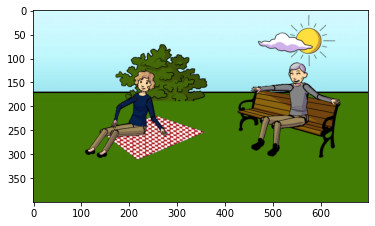

In [88]:

augmented_img = next(iterator)


image = augmented_img[0][0]   # First element

tf.print (augmented_img[1][0])
tf.print (augmented_img[2][0])

plt.imshow(np.uint8(image))
plt.plot

In [89]:
#Loading of VGG that will be used as a Backbone
vgg = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))

# for layer in vgg.layers:
#   layer.trainable = False
freeze_until = 18 # layer from which we want to fine-tune

for layer in vgg.layers[:freeze_until]:
    layer.trainable = False
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 400, 700, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 400, 700, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 400, 700, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 200, 350, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 200, 350, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 200, 350, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 100, 175, 128)     0     

In [129]:
# This function is used for creating a model without skip connections
def create_model():

    model = tf.keras.Sequential()
    model2 = tf.keras.Sequential()
    # Encoder
    # -------
    model.add(vgg)
    model2.add(model_lstm)
    
    scores = tf.keras.layers.Multiply()([model.output, model2.output])
    
    denso = tf.keras.layers.Dense(units=256, activation='selu')(scores)

    output = tf.keras.layers.Dense(units=58, activation='softmax')(denso)
    
    final_model = tf.keras.Model([model.inputs,model2.inputs], output)


    return final_model

In [130]:
model = create_model()

In [131]:
model.summary()

Model: "functional_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
vgg16_input (InputLayer)        [(None, 400, 700, 3) 0                                            
__________________________________________________________________________________________________
functional_11_input (InputLayer [(None, 9)]          0                                            
__________________________________________________________________________________________________
vgg16 (Functional)              (None, 12, 21, 512)  14714688    vgg16_input[0][0]                
__________________________________________________________________________________________________
functional_11 (Functional)      (None, 512)          1223840     functional_11_input[0][0]        
______________________________________________________________________________________

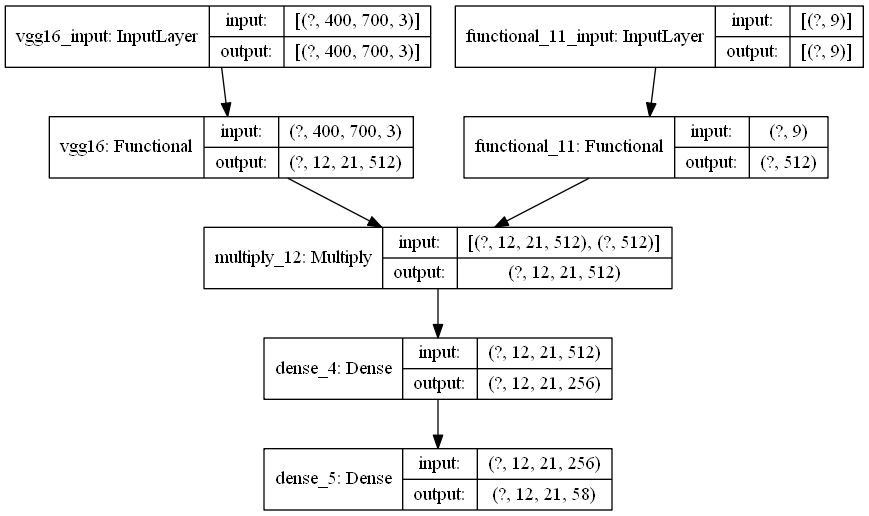

In [132]:
tf.keras.utils.plot_model(model, show_shapes=True)


In [133]:
# Optimization params
# -------------------

# Loss
# Sparse Categorical Crossentropy to use integers (mask) instead of one-hot encoded labels
loss = tf.keras.losses.SparseCategoricalCrossentropy() 


# learning rate
lr = 1e-6
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------

# Here we define the intersection over union for each class in the batch.
# Then we compute the final iou as the mean over classes
def meanIoU(y_true, y_pred):
    # get predicted class from softmax
    y_pred = tf.expand_dims(tf.argmax(y_pred, -1), -1)

    per_class_iou = []

    for i in range(1,3): # exclude the background class 0
      # Get prediction and target related to only a single class (i)
      class_pred = tf.cast(tf.where(y_pred == i, 1, 0), tf.float32)
      class_true = tf.cast(tf.where(y_true == i, 1, 0), tf.float32)
      intersection = tf.reduce_sum(class_true * class_pred)
      union = tf.reduce_sum(class_true) + tf.reduce_sum(class_pred) - intersection
    
      iou = (intersection + 1e-7) / (union + 1e-7)
      per_class_iou.append(iou)

    return tf.reduce_mean(per_class_iou)

# Validation metrics
# ------------------
metrics = ['accuracy', meanIoU]
# ------------------

weights = [150,2,6]


# Compile Model
model.compile(optimizer=optimizer, loss=loss , metrics=metrics, loss_weights=weights)

In [135]:
import os
from datetime import datetime

cwd1 = os.getcwd()

exps_dir = os.path.join(cwd1, 'multiclass_exps')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'CNN'

exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                   save_weights_only=True)  # False to save the model directly
callbacks.append(ckpt_callback)

# Visualize Learning on Tensorboard
# ---------------------------------
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=0)  # if 1 shows weights histograms
callbacks.append(tb_callback)

# Early Stopping
# --------------
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_meanIoU', patience=20, mode="max")
    callbacks.append(es_callback)


model.fit(x=train_dataset,
          epochs=100,  #### set repeat in training dataset
          steps_per_epoch=len(dataset),#+len(dataset1)
          validation_data=valid_dataset,
          validation_steps=len(dataset_valid), #+len(dataset_valid1)
          callbacks=callbacks)

# How to visualize Tensorboard

# 1. tensorboard --logdir EXPERIMENTS_DIR --port PORT     <- from terminal
# 2. localhost:PORT   <- in your browser

Epoch 1/100


AssertionError: in user code:

    C:\Users\ASUS\anaconda3\envs\tf_env\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    C:\Users\ASUS\anaconda3\envs\tf_env\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\ASUS\anaconda3\envs\tf_env\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\ASUS\anaconda3\envs\tf_env\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\ASUS\anaconda3\envs\tf_env\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\ASUS\anaconda3\envs\tf_env\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    C:\Users\ASUS\anaconda3\envs\tf_env\lib\site-packages\tensorflow\python\keras\engine\training.py:747 train_step
        y_pred = self(x, training=True)
    C:\Users\ASUS\anaconda3\envs\tf_env\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\ASUS\anaconda3\envs\tf_env\lib\site-packages\tensorflow\python\keras\engine\functional.py:386 call
        inputs, training=training, mask=mask)
    C:\Users\ASUS\anaconda3\envs\tf_env\lib\site-packages\tensorflow\python\keras\engine\functional.py:517 _run_internal_graph
        assert x_id in tensor_dict, 'Could not compute output ' + str(x)

    AssertionError: Could not compute output Tensor("dense_5/truediv:0", shape=(None, 12, 21, 58), dtype=float32)


import time
import matplotlib.pyplot as plt

from PIL import Image

%matplotlib inline

iterator = iter(valid_dataset)

C:\Users\ASUS\anaconda3\envs\tf_env\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


(1, 768, 512, 3)

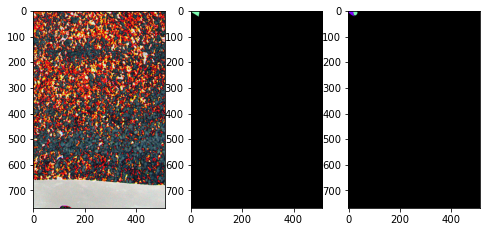

In [54]:
#model.load_weights(os.path.join(os.getcwd(),'multiclass_exps/CNN_Dec15_01-23-05/ckpts/cp.ckpt'))

fig, ax = plt.subplots(1, 3, figsize=(8, 8))
fig.show()
image, target = next(iterator)

image = image[0]
target = target[0, ..., 0]

out_sigmoid = model.predict(x=tf.expand_dims(image, 0))

# Get predicted class as the index corresponding to the maximum value in the vector probability
# predicted_class = tf.cast(out_sigmoid > score_th, tf.int32)
# predicted_class = predicted_class[0, ..., 0]
predicted_class = tf.argmax(out_sigmoid, -1)

out_sigmoid.shape

predicted_class = predicted_class[0, ...]

# Assign colors (just for visualization)
target_img = np.zeros([target.shape[0], target.shape[1], 3])
prediction_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = [0, 0, 0]
for i in range(1, 3):
  target_img[np.where(target == i)] = np.array(colors[i-1])[:3] * 255

prediction_img[np.where(predicted_class == 0)] = [0, 0, 0]
for i in range(1, 3):
  prediction_img[np.where(predicted_class == i)] = np.array(colors[i-1])[:3] * 255

ax[0].imshow(np.uint8(image))
ax[1].imshow(np.uint8(target_img))
ax[2].imshow(np.uint8(prediction_img))

fig.canvas.draw()
time.sleep(1)

In [43]:
submission_dict = {} 

for i in range(0,8):
    image_filenames = next(os.walk(os.path.join(test_dir[i],"Images/")))[2]

    if i in range(4,6):
        suffix = ".png"
    else:
        suffix = ".jpg"
    
    print (suffix)
    for image_name in image_filenames:
    
    
        image_name=image_name[:-4]
        img = Image.open(os.path.join(test_dir[i], 'Images', image_name + suffix))
        #mask = rme.read_rgb_mask(os.path.join(self.dataset_dir, 'Masks', curr_filename + '.png'))

        # Resize image and mask
        img = img.resize([2048,1536])
        

        
        # mask = mask.resize(self.out_shape)
    
        img_arr = preprocess_input( tf.expand_dims(np.array(img), 0))


        patches = tf.image.extract_patches(images=img_arr,
                                sizes=[1, img_h, img_w, 1],
                                strides=[1, img_h, img_w, 1],
                                rates=[1, 1, 1, 1],
                                padding='VALID')
        patches = tf.reshape(patches, [8, 768, 512, 3])

        predictions = []

        for j in range (0,8):
            out_sigmoid = model.predict(x=tf.expand_dims(patches[j],0))

            predicted_class = np.argmax(out_sigmoid, -1)
            predicted_class = predicted_class[0, ...]



            predictions.append(predicted_class)



        total = tf.concat([predictions[0], predictions[4]], 0)

        for x in range (1,4):
            result=tf.concat([predictions[x], predictions[x+4]], 0)
            total=tf.concat([total, result], 1)
    
        mask_arr = np.array(total)
        submission_dict[image_name] = {}
        submission_dict[image_name]['shape'] = [1536,2048]
        submission_dict[image_name]['team'] = teams[math.floor(i/2)]
        submission_dict[image_name]['crop'] = crops[i%2]
        submission_dict[image_name]['segmentation'] = {}

        # RLE encoding
        # crop
        rle_encoded_crop = ps.rle_encode(mask_arr == 1)
        # weed
        rle_encoded_weed = ps.rle_encode(mask_arr == 2)

        submission_dict[image_name]['segmentation']['crop'] = rle_encoded_crop
        submission_dict[image_name]['segmentation']['weed'] = rle_encoded_weed

        # Please notice that in this example we have a single prediction.
        # For the competition you have to provide segmentation for each of
        # the test images.

        # Finally, save the results into the submission.json file
with open(os.path.join(dataset_dir[0],"submission.json"), 'w') as f:
    json.dump(submission_dict, f)
    
    

.jpg
.jpg
.jpg
.jpg
.png
.png
.jpg
.jpg


image_filenames = next(os.walk(os.path.join(test_dir,"Images/")))[2]

for image_name in image_filenames:
    image_name=image_name[:-4]
    img = Image.open(os.path.join(test_dir, 'Images', image_name + '.jpg'))
    #mask = rme.read_rgb_mask(os.path.join(self.dataset_dir, 'Masks', curr_filename + '.png'))

    # Resize image and mask
    img = img.resize([img_w,img_h])
        

        
    # mask = mask.resize(self.out_shape)
    
    img_arr = np.array(img)
    model.predict(x=tf.expand_dims(img_arr, 0))

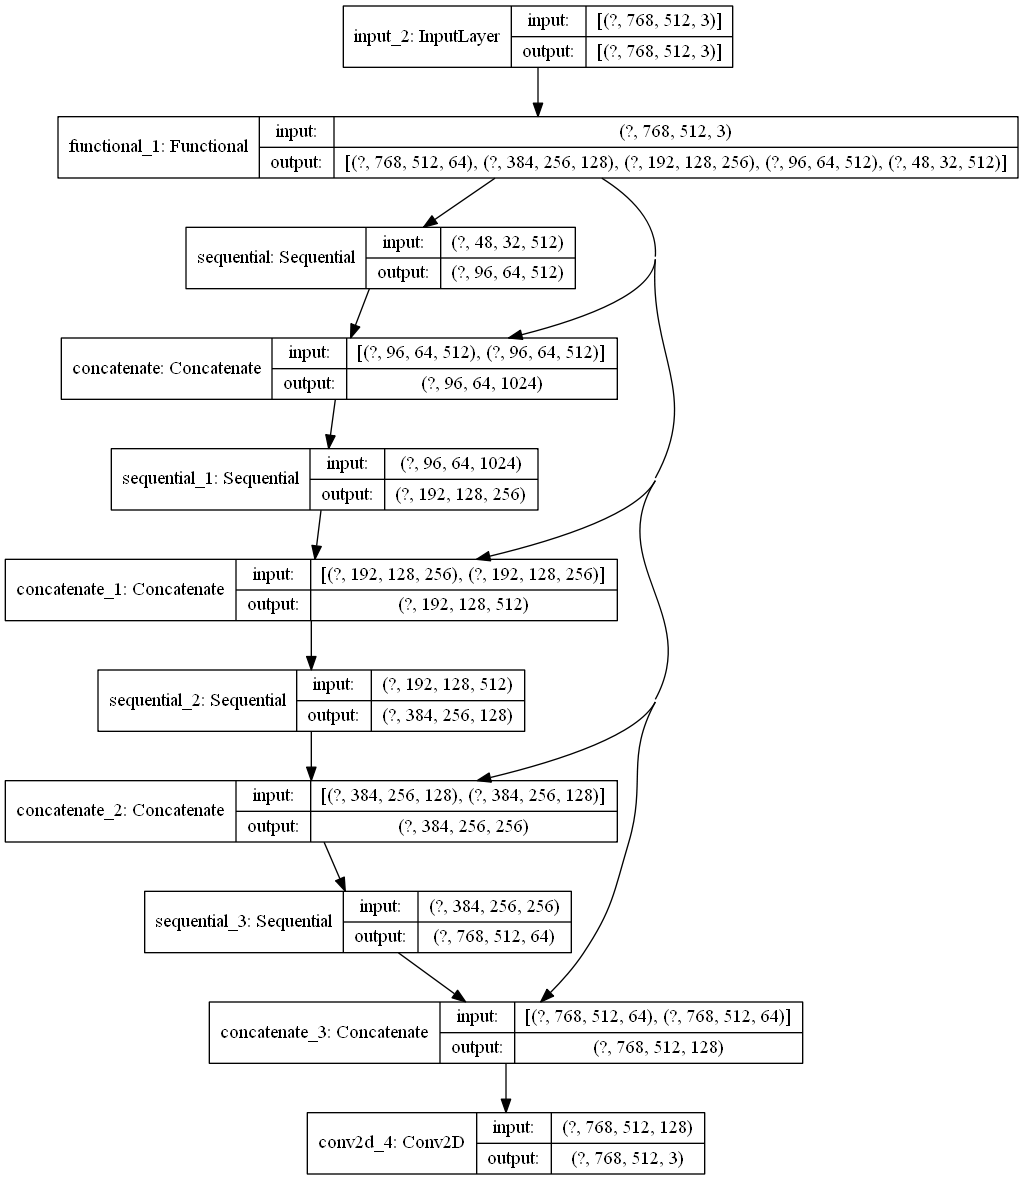

In [24]:

tf.keras.utils.plot_model(model, show_shapes=True)


C:\Users\ASUS\anaconda3\envs\tf_env\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


(1, 768, 512, 3)

(1, 768, 512, 3)

(1, 768, 512, 3)

(1, 768, 512, 3)

(1, 768, 512, 3)

(1, 768, 512, 3)

(1, 768, 512, 3)

(1, 768, 512, 3)

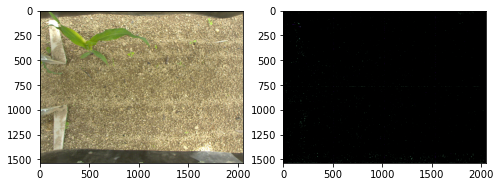

In [25]:
#model.load_weights(os.path.join(os.getcwd(),'multiclass_exps/CNN_Dec15_01-23-05/ckpts/cp.ckpt'))

fig, ax = plt.subplots(1, 2, figsize=(8, 8))
fig.show()

image = Image.open(os.path.join(test_dir[0], 'Images/Bipbip_mais_im_01931.jpg'))
#mask = rme.read_rgb_mask(os.path.join(self.dataset_dir, 'Masks', curr_filename + '.png'))
         

img_arr = preprocess_input( tf.expand_dims(np.array(image), 0))


patches = tf.image.extract_patches(images=img_arr,
                        sizes=[1, img_h, img_w, 1],
                        strides=[1, img_h, img_w, 1],
                        rates=[1, 1, 1, 1],
                        padding='VALID')
patches = tf.reshape(patches, [8, 768, 512, 3])


# Resize image and mask
#image = image.resize([img_w,img_h])

predictions = []

for j in range (0,8):
    out_sigmoid = model.predict(x=tf.expand_dims(patches[j],0))

    # Get predicted class as the index corresponding to the maximum value in the vector probability
    # predicted_class = tf.cast(out_sigmoid > score_th, tf.int32)
    # predicted_class = predicted_class[0, ..., 0]
    predicted_class = tf.argmax(out_sigmoid, -1)

    out_sigmoid.shape

    predicted_class = predicted_class[0, ...]

    prediction_img = np.zeros([img_h, img_w, 3])


    prediction_img[np.where(predicted_class == 0)] = [0, 0, 0]
    for i in range(1, 3):
      prediction_img[np.where(predicted_class == i)] = np.array(colors[i-1])[:3] * 255

#     ax[0].imshow(np.uint8(patches[j]))
#     ax[1].imshow(np.uint8(prediction_img))

    predictions.append(prediction_img)
    
    fig.canvas.draw()
    time.sleep(1)
    
total = tf.concat([predictions[0], predictions[4]], 0)

for x in range (1,4):
    result=tf.concat([predictions[x], predictions[x+4]], 0)
    total=tf.concat([total, result], 1)
    
ax[0].imshow(np.uint8(image))
ax[1].imshow(np.uint8(total))

In [58]:
model.save_weights(os.path.join(os.getcwd(),'multiclass_exps/Manual/ckpts/cp.ckpt'))
